**2D nonlinear diffusion-reaction system**

In [11]:
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from sys import stderr
from scipy import stats
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.interpolate import griddata
from matplotlib.pyplot import scatter, figure
from torch.utils.data import TensorDataset, DataLoader

seed = 10
batch_size = 500
noise_scale = 0.01
num_samples = 1000
num_sensors = 100

np.random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(4, 4)})
sns.set_style("whitegrid")

class Experiment(nn.Module):
    def __init__(self):
        super(Experiment, self).__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        print(self.device)

        self.optimizer = None
        self.train_loss_history = []
        self.w_int = 1
        self.w_data = 1
        self.w_bc = 1
        self.w_param_std = 1
        self.numInputs = 2
        self.numParams = 1
        self.numOutputs = 2
        self.hidden_size = 300

        # Initialize history variables
        self.total_loss_history = []
        self.loss_interior_history = []
        self.loss_data_history = []
        self.loss_bc_history = []
        self.loss_std_history = []

        self.predicted_params = torch.zeros((batch_size,self.numParams), requires_grad=True, device=self.device)

        # We have 2 input feature
        self.b1 = nn.Linear(self.numInputs, self.hidden_size).to(self.device)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.b3 = nn.Linear(self.hidden_size, self.numOutputs).to(self.device)

        self.t1 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t3 = nn.Linear(self.hidden_size, self.numParams).to(self.device)


    def create_dataset(self, noise_scale=0.01, num_samples=100, lambd=0.01, k=1.0):
        # Generate x and y points evenly spaced between -1 and 1
        x = torch.linspace(-1, 1, num_samples, device=self.device)  # Space domain for x
        y = torch.linspace(-1, 1, num_samples, device=self.device)  # Space domain for y

        x_grid, y_grid = torch.meshgrid(x, y, indexing="ij")
        u = exact_solution(x_grid, y_grid)
        f = source_term(x_grid, y_grid)

        self.indices = np.random.choice(x_grid.numel(), num_samples, replace=False)

        # Extract sensor locations and their corresponding u and f values
        self.sensor_x = x_grid.reshape(-1)[self.indices]
        self.sensor_y = y_grid.reshape(-1)[self.indices]
        self.sensor_u = (u.reshape(-1)[self.indices] + torch.randn(num_samples, device=self.device) * noise_scale)
        self.sensor_f = (f.reshape(-1)[self.indices] + torch.randn(num_samples, device=self.device) * noise_scale)

        # Optional: Plot the u and f distribution with sensor locations
        plot_u_f_distribution(x_grid, y_grid, u, f, self.sensor_x, self.sensor_y)


    def forward(self, x, y):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x).float().to(self.device)

        if not torch.is_tensor(y):
            y = torch.from_numpy(y).float().to(self.device)


        # Add a dimension if it's not already there
        x = x.unsqueeze(1) if x.dim() == 1 else x
        y = y.unsqueeze(1) if y.dim() == 1 else y


        input = torch.cat((x, y), 1)
        h1 = torch.tanh(self.b1(input))
        h2 = torch.tanh(self.b2(h1))

        prior_param_sample = torch.rand(x.shape[0], self.hidden_size , device=self.device).requires_grad_(True)

        t1 = torch.tanh(self.t1(prior_param_sample))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_sample = self.t3(t2)
        self.predicted_params = posterior_param_sample

        output = self.b3(torch.multiply(t2, h2))

        # Split the output into u and f, each of shape [100]
        u = output[:, 0]
        f = output[:, 1]

        return u, f


    # General formula to compute the n-th order derivative of y = f(x) with respect to x
    def compute_derivative(self, y, x, n):
        if n == 0:
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y, device= self.device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]
        return self.compute_derivative(dy_dx, x, n - 1)


    def PDE_residual(self, x, y, lambd=0.01):
        u, f = self.forward(x, y)
        du_dx = self.compute_derivative(u, x, 1)
        du_dy = self.compute_derivative(u, y, 1)
        d2u_dx2 = self.compute_derivative(u, x, 2)
        d2u_dy2 = self.compute_derivative(u, y, 2)
        u_squared = u ** 2  # Shape [100]
        u_squared = u_squared.view(-1, 1)

        # residual = lambda(d2u_dx2 + d2u_dy2) + k * (u**2) + f
        residual = torch.multiply(lambd, (d2u_dx2 + d2u_dy2)).view(-1, 1) \
        + torch.multiply(self.predicted_params, u_squared) - f.view(-1, 1)
        return residual


    def loss_boundary_condition(self):
        num_sensors_per_side = 25
        points = torch.linspace(-1, 1, num_sensors_per_side, device = self.device)

        x_bottom, y_bottom = points, -torch.ones(num_sensors_per_side, device = self.device)
        x_top, y_top = points, torch.ones(num_sensors_per_side, device = self.device)
        x_left, y_left = -torch.ones(num_sensors_per_side, device = self.device), points
        x_right, y_right = torch.ones(num_sensors_per_side, device = self.device), points

        # Concatenating all x and y coordinates
        self.all_x = torch.cat([x_bottom, x_top, x_left, x_right]).requires_grad_(True)
        self.all_y = torch.cat([y_bottom, y_top, y_left, y_right]).requires_grad_(True)

        loss, _ = self.forward(self.all_x, self.all_y)
        boundary_loss = torch.abs(loss).sum()
        
        # boundary_loss = torch.tensor([0.0]).to(device)

        return boundary_loss
    
    
    def sample_boundary_points_interior_loss(self):
        num_sensors_per_side = 200
        points = 2*torch.rand((num_sensors_per_side,), device=self.device).requires_grad_(True)  - 1.0
        
        x_bottom, y_bottom = points, -torch.ones(num_sensors_per_side, device = self.device)
        x_top, y_top = points, torch.ones(num_sensors_per_side, device = self.device)
        x_left, y_left = -torch.ones(num_sensors_per_side, device = self.device), points
        x_right, y_right = torch.ones(num_sensors_per_side, device = self.device), points

        
        # Concatenating all x and y coordinates
        x = torch.cat([x_bottom, x_top, x_left, x_right]).requires_grad_(True)
        y = torch.cat([y_bottom, y_top, y_left, y_right]).requires_grad_(True)
        
        return x, y

    
    
    def loss_interior(self, num_samples=5000):
        interior_x_samples = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        interior_y_samples = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        res1 = self.PDE_residual(interior_x_samples, interior_y_samples)
        res2 = self.PDE_residual(self.all_x, self.all_y)
        loss_residual1 = torch.mean(torch.square(res1))
        loss_residual2 = torch.mean(torch.square(res2))
        
        

        x, y = self.sample_boundary_points_interior_loss()
        loss_residual3 = torch.mean(torch.square(self.PDE_residual(x, y)))
        
        return loss_residual1 + loss_residual2 + loss_residual3


    def loss_data(self):
        u_pred, f_pred = self.forward(self.sensor_x, self.sensor_y)
        loss_u = torch.mean(torch.square(u_pred - self.sensor_u))
        loss_f = torch.mean(torch.square(f_pred - self.sensor_f))
        return loss_u + loss_f


#     def loss_interior(self, num_samples=100):
#         interior_x_samples = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
#         interior_y_samples = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
#         res1 = self.PDE_residual(interior_x_samples, interior_y_samples)
#         res2 = self.PDE_residual(self.all_x, self.all_y)
#         loss_residual1 = torch.mean(torch.square(res1))
#         loss_residual2 = torch.mean(torch.square(res2))
#         return loss_residual1 + loss_residual2


    def compute_losses(self):
        loss_bc = self.loss_boundary_condition()
        loss_interior = self.loss_interior()
        loss_data = self.loss_data()
        return loss_bc, loss_interior, loss_data


    def sample_parameter_posterior(self, num_samples=500):
        prior_param_samples = torch.rand(num_samples, self.hidden_size, device=self.device).requires_grad_(True)
        t1 = torch.tanh(self.t1(prior_param_samples))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_samples = self.t3(t2)
        return posterior_param_samples


    def update_predicted_params(self, posterior_samples):
        mean = torch.mean(posterior_samples, dim=0)  # Compute the mean along the first axis
        std = torch.std(posterior_samples, dim=0)    # Compute the standard deviation along the first axis

        self.predicted_params = posterior_samples
        self.mean_predicted_params = mean  # Store the mean
        self.std_params = std  # Attach the standard deviation as an attribute


    def closure(self):
        self.optimizer.zero_grad()
        loss_bc, loss_interior, loss_data = self.compute_losses()
        total_loss = self.w_bc * loss_bc \
                    + self.w_int * loss_interior \
                    + self.w_data * loss_data 


        # Sample the parameter posterior and update self.predicted_params and self.std_params
        posterior_samples = self.sample_parameter_posterior(num_samples=100)
        self.update_predicted_params(posterior_samples)

        # Add the (Log(std))**2 term to the loss with the specified weight
        # Add the (Log(w * std))**2 term to the loss with the specified weight
        self.log_std_squared_loss = torch.mean(torch.log(self.w_param_std * self.std_params)**2)
        total_loss += self.log_std_squared_loss

        total_loss.backward(retain_graph=True)
        return total_loss


    def train(self, epochs, optimizer='Adam', **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=3, verbose=True)


        # Training loop
#         for epoch in range(epochs):
        for epoch in tqdm(range(epochs), desc="Training Progress", unit="epoch"):
            self.optimizer.step(self.closure)
            if epoch % 1000 == 0:
                loss_bc, loss_interior, loss_data = self.compute_losses()
                
                total_loss = loss_bc + loss_interior + loss_data  + self.log_std_squared_loss

                scheduler.step(total_loss)

                # Append losses to history
                self.total_loss_history.append(total_loss.item())
                self.loss_interior_history.append(loss_interior.item())
                self.loss_data_history.append(loss_data.item())
                self.loss_bc_history.append(loss_bc.item())
                self.loss_std_history.append(self.log_std_squared_loss.item())

                print(f'Epoch({optimizer}):{epoch},  Total Loss:{total_loss.item():.4f}  ' \
                        f'PDE Loss:{loss_interior.item():.4f}  ' \
                        f'BC Loss:{loss_bc.item():.4f}  ' \
                        f'Data Loss: {loss_data.item():.4f}  ' \
                        f'Mean Predicted Param 1: {self.mean_predicted_params[0]:.4f} ' \
                        f'Std Params:{self.std_params.detach().cpu().numpy()[0]:.4f}  ' \
                        f'Std Log Loss:{self.log_std_squared_loss.item():.4f}')

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

cuda:0


In [13]:
# exact solution
def exact_solution(x, y):
    return torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

# function f
def source_term(x, y, lambd=0.01, k=1.0):
    u = exact_solution(x, y)
    f = -1/50.0 * torch.pi**2 * (u) + u**2
    return f

In [14]:
def plot_u_f_distribution(x_grid, y_grid, u, f, sensor_x, sensor_y):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Subplot for 'u'
    contour1 = axes[0].contourf(x_grid.cpu().detach().numpy(), y_grid.cpu().detach().numpy(), u.cpu().detach().numpy(), cmap='jet', levels=40, vmin=-1, vmax=1)
    scatter_u = axes[0].scatter(sensor_x.cpu().detach().numpy(), sensor_y.cpu().detach().numpy(), cmap='jet', facecolors='none', marker='o', edgecolor='black', s=40, linewidths=2, label="training sample for u")
    fig.colorbar(contour1, ax=axes[0])
    axes[0].set_title('Distribution of u')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True)

    # Subplot for 'f'
    contour2 = axes[1].contourf(x_grid.cpu().detach().numpy(), y_grid.cpu().detach().numpy(), f.cpu().detach().numpy(), cmap='jet', levels=40, vmin=0, vmax=1)
    scatter_f = axes[1].scatter(sensor_x.cpu().detach().numpy(), sensor_y.cpu().detach().numpy(),  cmap='jet', color='black', marker='x', s=40, linewidths=2, label="training sample for s")
    fig.colorbar(contour2, ax=axes[1])
    axes[1].set_title('Distribution of f')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True)

    plt.tight_layout()
    plt.show()

In [15]:
def make_plot(model, device=device):
    # Generate test data
    num_test_samples = 100
    x_test = torch.linspace(-1, 1, num_test_samples, device=device)
    y_test = torch.linspace(-1, 1, num_test_samples, device=device)
    x_grid, y_grid = torch.meshgrid(x_test, y_test, indexing="ij")

    x_flat = x_grid.reshape(-1)
    y_flat = y_grid.reshape(-1)

    u_preds = []
    f_preds = []

    # Process in batches
    batch_size = 100
    num_batches = (x_flat.size(0) + batch_size - 1) // batch_size  # Calculate the number of batches needed

    model.eval()
    with torch.no_grad():
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, x_flat.size(0))

            # Slice the batch
            x_batch = x_flat[start_idx:end_idx]
            y_batch = y_flat[start_idx:end_idx]

            # Predict for this batch
            u_pred, f_pred = model.forward(x_batch, y_batch)

            # Collect predictions
            u_preds.append(u_pred)
            f_preds.append(f_pred)

    # Concatenate all batched predictions
    u_preds = torch.cat(u_preds, dim=0)
    f_preds = torch.cat(f_preds, dim=0)

    # Reshape predictions to match the grid shape
    u_preds = u_preds.view(num_test_samples, num_test_samples)
    f_preds = f_preds.view(num_test_samples, num_test_samples)

    # Compute the exact solutions for comparison
    u_exact = exact_solution(x_grid, y_grid)
    f_exact = source_term(x_grid, y_grid)

    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot predicted 'u'
    contour1 = axes[0, 0].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(), u_preds.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(contour1, ax=axes[0, 0])
    axes[0, 0].set_title('Predicted u')
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('y')

    # Plot exact 'u'
    contour2 = axes[0, 1].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(), u_exact.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(contour2, ax=axes[0, 1])
    axes[0, 1].set_title('Exact u')
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('y')

    # Plot predicted 'f'
    contour3 = axes[1, 0].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(), f_preds.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(contour3, ax=axes[1, 0])
    axes[1, 0].set_title('Predicted f')
    axes[1, 0].set_xlabel('x')
    axes[1, 0].set_ylabel('y')

    # Plot exact 'f'
    contour4 = axes[1, 1].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(), f_exact.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(contour4, ax=axes[1, 1])
    axes[1, 1].set_title('Exact f')
    axes[1, 1].set_xlabel('x')
    axes[1, 1].set_ylabel('y')

    plt.tight_layout()
    plt.savefig('result_plot.png', dpi=400)  # Save the figure as a PNG file with 400 DPI
    plt.show()

In [16]:
net = Experiment()
net.to(net.device)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

cuda:0
Params: 272703


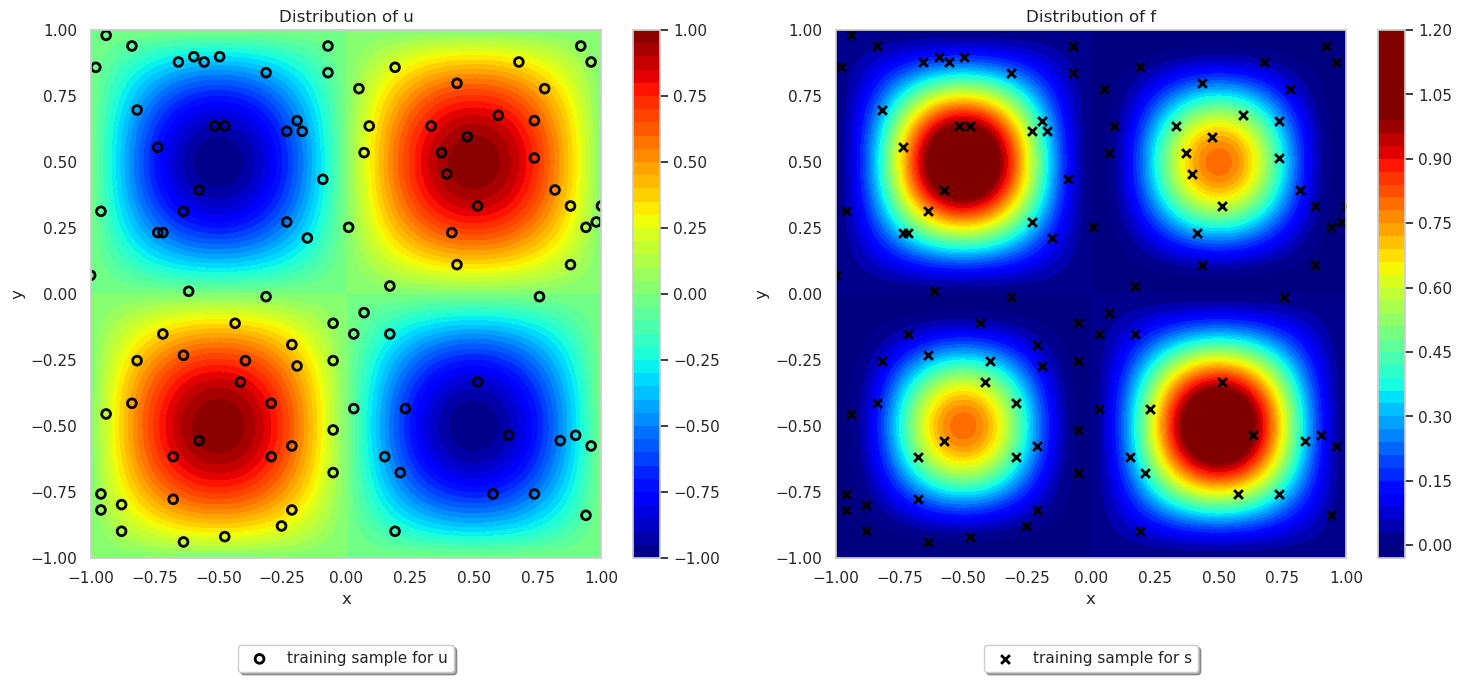

In [17]:
net.create_dataset()

In [18]:
# net.w_int = 0.8
# net.w_data = 11
#  net.w_bc   = 0.8
# net.w_param_std = 0

In [19]:
net.w_int = 20000
net.w_data = 60000
net.w_bc   = 100
net.w_param_std = 20

In [20]:
torch.autograd.set_detect_anomaly(True)
net.train(35000, optimizer='Adam', lr=1e-3)

Training Progress:   0%|          | 2/35000 [00:00<1:46:11,  5.49epoch/s]

Epoch(Adam):0,  Total Loss:11.8642  PDE Loss:0.1480  BC Loss:11.3858  Data Loss: 0.3044  Mean Predicted Param 1: 0.0070 Std Params:0.0426  Std Log Loss:0.0260


Training Progress:   3%|▎         | 1002/35000 [02:02<1:17:50,  7.28epoch/s]

Epoch(Adam):1000,  Total Loss:3.6612  PDE Loss:0.0039  BC Loss:2.5856  Data Loss: 0.0023  Mean Predicted Param 1: 0.9962 Std Params:0.0178  Std Log Loss:1.0693


Training Progress:   6%|▌         | 2002/35000 [04:09<1:21:55,  6.71epoch/s]

Epoch(Adam):2000,  Total Loss:2.6413  PDE Loss:0.0013  BC Loss:1.4757  Data Loss: 0.0006  Mean Predicted Param 1: 0.9435 Std Params:0.0170  Std Log Loss:1.1637


Training Progress:   9%|▊         | 3002/35000 [06:16<1:13:58,  7.21epoch/s]

Epoch(Adam):3000,  Total Loss:2.1341  PDE Loss:0.0013  BC Loss:1.1909  Data Loss: 0.0005  Mean Predicted Param 1: 0.9804 Std Params:0.0189  Std Log Loss:0.9414


Training Progress:  11%|█▏        | 4002/35000 [08:28<1:14:14,  6.96epoch/s]

Epoch(Adam):4000,  Total Loss:1.7762  PDE Loss:0.0007  BC Loss:0.8822  Data Loss: 0.0003  Mean Predicted Param 1: 0.9864 Std Params:0.0194  Std Log Loss:0.8930


Training Progress:  14%|█▍        | 5002/35000 [10:37<1:07:26,  7.41epoch/s]

Epoch(Adam):5000,  Total Loss:1.7405  PDE Loss:0.0007  BC Loss:0.9298  Data Loss: 0.0003  Mean Predicted Param 1: 0.9904 Std Params:0.0203  Std Log Loss:0.8097


Training Progress:  17%|█▋        | 6002/35000 [12:36<1:06:24,  7.28epoch/s]

Epoch(Adam):6000,  Total Loss:1.8027  PDE Loss:0.0006  BC Loss:0.6468  Data Loss: 0.0002  Mean Predicted Param 1: 0.9777 Std Params:0.0171  Std Log Loss:1.1551


Training Progress:  20%|██        | 7002/35000 [14:36<1:02:35,  7.46epoch/s]

Epoch(Adam):7000,  Total Loss:2.0136  PDE Loss:0.0007  BC Loss:1.0141  Data Loss: 0.0003  Mean Predicted Param 1: 1.0183 Std Params:0.0184  Std Log Loss:0.9985


Training Progress:  23%|██▎       | 8002/35000 [16:35<59:42,  7.54epoch/s]  

Epoch(Adam):8000,  Total Loss:1.3340  PDE Loss:0.0007  BC Loss:0.4864  Data Loss: 0.0002  Mean Predicted Param 1: 0.9917 Std Params:0.0199  Std Log Loss:0.8468


Training Progress:  26%|██▌       | 9002/35000 [18:35<59:01,  7.34epoch/s]  

Epoch(Adam):9000,  Total Loss:1.6034  PDE Loss:0.0005  BC Loss:0.6860  Data Loss: 0.0002  Mean Predicted Param 1: 0.9743 Std Params:0.0192  Std Log Loss:0.9167


Training Progress:  29%|██▊       | 10002/35000 [20:34<55:56,  7.45epoch/s] 

Epoch(Adam):10000,  Total Loss:1.6045  PDE Loss:0.0004  BC Loss:0.5806  Data Loss: 0.0001  Mean Predicted Param 1: 0.9717 Std Params:0.0182  Std Log Loss:1.0234


Training Progress:  31%|███▏      | 11002/35000 [22:35<55:19,  7.23epoch/s]  

Epoch(Adam):11000,  Total Loss:1.7488  PDE Loss:0.0004  BC Loss:0.8251  Data Loss: 0.0002  Mean Predicted Param 1: 1.0059 Std Params:0.0191  Std Log Loss:0.9231


Training Progress:  34%|███▍      | 12002/35000 [24:34<51:37,  7.43epoch/s]

Epoch(Adam):12000,  Total Loss:1.8114  PDE Loss:0.0003  BC Loss:0.7185  Data Loss: 0.0001  Mean Predicted Param 1: 1.0028 Std Params:0.0176  Std Log Loss:1.0925


Training Progress:  37%|███▋      | 13002/35000 [26:34<49:51,  7.35epoch/s]

Epoch(Adam):13000,  Total Loss:0.7444  PDE Loss:0.0002  BC Loss:0.1017  Data Loss: 0.0001  Mean Predicted Param 1: 0.9949 Std Params:0.0224  Std Log Loss:0.6424


Training Progress:  40%|████      | 14002/35000 [28:35<47:31,  7.36epoch/s]

Epoch(Adam):14000,  Total Loss:1.2764  PDE Loss:0.0002  BC Loss:0.1249  Data Loss: 0.0001  Mean Predicted Param 1: 0.9894 Std Params:0.0171  Std Log Loss:1.1512


Training Progress:  43%|████▎     | 15002/35000 [30:35<45:17,  7.36epoch/s]

Epoch(Adam):15000,  Total Loss:1.0080  PDE Loss:0.0002  BC Loss:0.1076  Data Loss: 0.0001  Mean Predicted Param 1: 0.9896 Std Params:0.0194  Std Log Loss:0.9001


Training Progress:  46%|████▌     | 16002/35000 [32:35<42:09,  7.51epoch/s]

Epoch(Adam):16000,  Total Loss:1.0027  PDE Loss:0.0002  BC Loss:0.1142  Data Loss: 0.0001  Mean Predicted Param 1: 0.9924 Std Params:0.0195  Std Log Loss:0.8882


Training Progress:  49%|████▊     | 17002/35000 [34:33<39:57,  7.51epoch/s]

Epoch(Adam):17000,  Total Loss:0.9493  PDE Loss:0.0002  BC Loss:0.1051  Data Loss: 0.0001  Mean Predicted Param 1: 0.9952 Std Params:0.0200  Std Log Loss:0.8439


Training Progress:  51%|█████▏    | 18002/35000 [36:33<37:48,  7.49epoch/s]

Epoch(Adam):18000,  Total Loss:0.9939  PDE Loss:0.0002  BC Loss:0.0592  Data Loss: 0.0001  Mean Predicted Param 1: 0.9914 Std Params:0.0190  Std Log Loss:0.9344


Training Progress:  54%|█████▍    | 19002/35000 [38:31<36:26,  7.32epoch/s]

Epoch(Adam):19000,  Total Loss:0.8341  PDE Loss:0.0002  BC Loss:0.0590  Data Loss: 0.0001  Mean Predicted Param 1: 0.9962 Std Params:0.0207  Std Log Loss:0.7748


Training Progress:  57%|█████▋    | 20002/35000 [40:29<33:31,  7.46epoch/s]

Epoch(Adam):20000,  Total Loss:1.0219  PDE Loss:0.0002  BC Loss:0.0590  Data Loss: 0.0001  Mean Predicted Param 1: 0.9914 Std Params:0.0187  Std Log Loss:0.9627


Training Progress:  60%|██████    | 21002/35000 [42:28<31:21,  7.44epoch/s]

Epoch(Adam):21000,  Total Loss:0.9058  PDE Loss:0.0002  BC Loss:0.0564  Data Loss: 0.0001  Mean Predicted Param 1: 0.9928 Std Params:0.0199  Std Log Loss:0.8491


Training Progress:  63%|██████▎   | 22001/35000 [44:27<30:07,  7.19epoch/s]

Epoch(Adam):22000,  Total Loss:1.0780  PDE Loss:0.0002  BC Loss:0.0536  Data Loss: 0.0001  Mean Predicted Param 1: 0.9947 Std Params:0.0182  Std Log Loss:1.0241


Training Progress:  66%|██████▌   | 23002/35000 [46:27<27:22,  7.31epoch/s]

Epoch(Adam):23000,  Total Loss:0.8365  PDE Loss:0.0002  BC Loss:0.0543  Data Loss: 0.0001  Mean Predicted Param 1: 0.9911 Std Params:0.0207  Std Log Loss:0.7819


Training Progress:  69%|██████▊   | 24002/35000 [48:28<25:11,  7.27epoch/s]

Epoch(Adam):24000,  Total Loss:1.0599  PDE Loss:0.0002  BC Loss:0.0542  Data Loss: 0.0001  Mean Predicted Param 1: 0.9921 Std Params:0.0183  Std Log Loss:1.0055


Training Progress:  71%|███████▏  | 25002/35000 [50:28<22:19,  7.46epoch/s]

Epoch(Adam):25000,  Total Loss:1.0107  PDE Loss:0.0002  BC Loss:0.0540  Data Loss: 0.0001  Mean Predicted Param 1: 0.9957 Std Params:0.0188  Std Log Loss:0.9564


Training Progress:  74%|███████▍  | 26002/35000 [52:29<20:28,  7.32epoch/s]

Epoch(Adam):26000,  Total Loss:1.0242  PDE Loss:0.0002  BC Loss:0.0536  Data Loss: 0.0001  Mean Predicted Param 1: 0.9936 Std Params:0.0187  Std Log Loss:0.9703


Training Progress:  77%|███████▋  | 27002/35000 [54:28<17:47,  7.49epoch/s]

Epoch(Adam):27000,  Total Loss:0.7159  PDE Loss:0.0002  BC Loss:0.0535  Data Loss: 0.0001  Mean Predicted Param 1: 0.9948 Std Params:0.0222  Std Log Loss:0.6621


Training Progress:  80%|████████  | 28002/35000 [56:27<15:56,  7.32epoch/s]

Epoch(Adam):28000,  Total Loss:1.2275  PDE Loss:0.0002  BC Loss:0.0540  Data Loss: 0.0001  Mean Predicted Param 1: 0.9946 Std Params:0.0169  Std Log Loss:1.1732


Training Progress:  83%|████████▎ | 29002/35000 [58:26<13:21,  7.48epoch/s]

Epoch(Adam):29000,  Total Loss:0.7820  PDE Loss:0.0002  BC Loss:0.0535  Data Loss: 0.0001  Mean Predicted Param 1: 0.9941 Std Params:0.0213  Std Log Loss:0.7282


Training Progress:  86%|████████▌ | 30002/35000 [1:00:25<11:17,  7.38epoch/s]

Epoch(Adam):30000,  Total Loss:0.6621  PDE Loss:0.0002  BC Loss:0.0538  Data Loss: 0.0001  Mean Predicted Param 1: 0.9927 Std Params:0.0229  Std Log Loss:0.6080


Training Progress:  89%|████████▊ | 31002/35000 [1:02:24<08:51,  7.52epoch/s]

Epoch(Adam):31000,  Total Loss:0.9642  PDE Loss:0.0002  BC Loss:0.0537  Data Loss: 0.0001  Mean Predicted Param 1: 0.9917 Std Params:0.0193  Std Log Loss:0.9102


Training Progress:  91%|█████████▏| 32002/35000 [1:04:23<06:38,  7.53epoch/s]

Epoch(Adam):32000,  Total Loss:1.1804  PDE Loss:0.0002  BC Loss:0.0537  Data Loss: 0.0001  Mean Predicted Param 1: 0.9943 Std Params:0.0173  Std Log Loss:1.1264


Training Progress:  94%|█████████▍| 33002/35000 [1:06:21<04:32,  7.34epoch/s]

Epoch(Adam):33000,  Total Loss:1.0887  PDE Loss:0.0002  BC Loss:0.0536  Data Loss: 0.0001  Mean Predicted Param 1: 0.9950 Std Params:0.0181  Std Log Loss:1.0348


Training Progress:  97%|█████████▋| 34002/35000 [1:08:19<02:13,  7.48epoch/s]

Epoch(Adam):34000,  Total Loss:0.8685  PDE Loss:0.0002  BC Loss:0.0539  Data Loss: 0.0001  Mean Predicted Param 1: 0.9945 Std Params:0.0203  Std Log Loss:0.8144


Training Progress: 100%|██████████| 35000/35000 [1:10:16<00:00,  8.30epoch/s]


In [21]:
net.predicted_params

tensor([[0.9905],
        [1.0053],
        [0.9976],
        [0.9841],
        [0.9782],
        [1.0163],
        [0.9954],
        [0.9803],
        [0.9778],
        [1.0130],
        [0.9724],
        [1.0036],
        [1.0070],
        [0.9777],
        [0.9891],
        [0.9840],
        [0.9950],
        [1.0297],
        [0.9753],
        [0.9537],
        [1.0215],
        [0.9601],
        [1.0062],
        [1.0035],
        [0.9745],
        [1.0046],
        [0.9786],
        [1.0144],
        [1.0358],
        [0.9422],
        [1.0379],
        [1.0012],
        [0.9727],
        [1.0033],
        [0.9882],
        [1.0093],
        [1.0001],
        [1.0208],
        [0.9946],
        [0.9901],
        [0.9817],
        [0.9685],
        [1.0055],
        [0.9827],
        [0.9813],
        [0.9956],
        [1.0094],
        [0.9746],
        [0.9986],
        [0.9538],
        [0.9702],
        [0.9895],
        [0.9599],
        [1.0058],
        [1.0061],
        [0

In [22]:
predicted_samples = net.predicted_params.clone()

Training Progress: 0epoch [00:00, ?epoch/s]


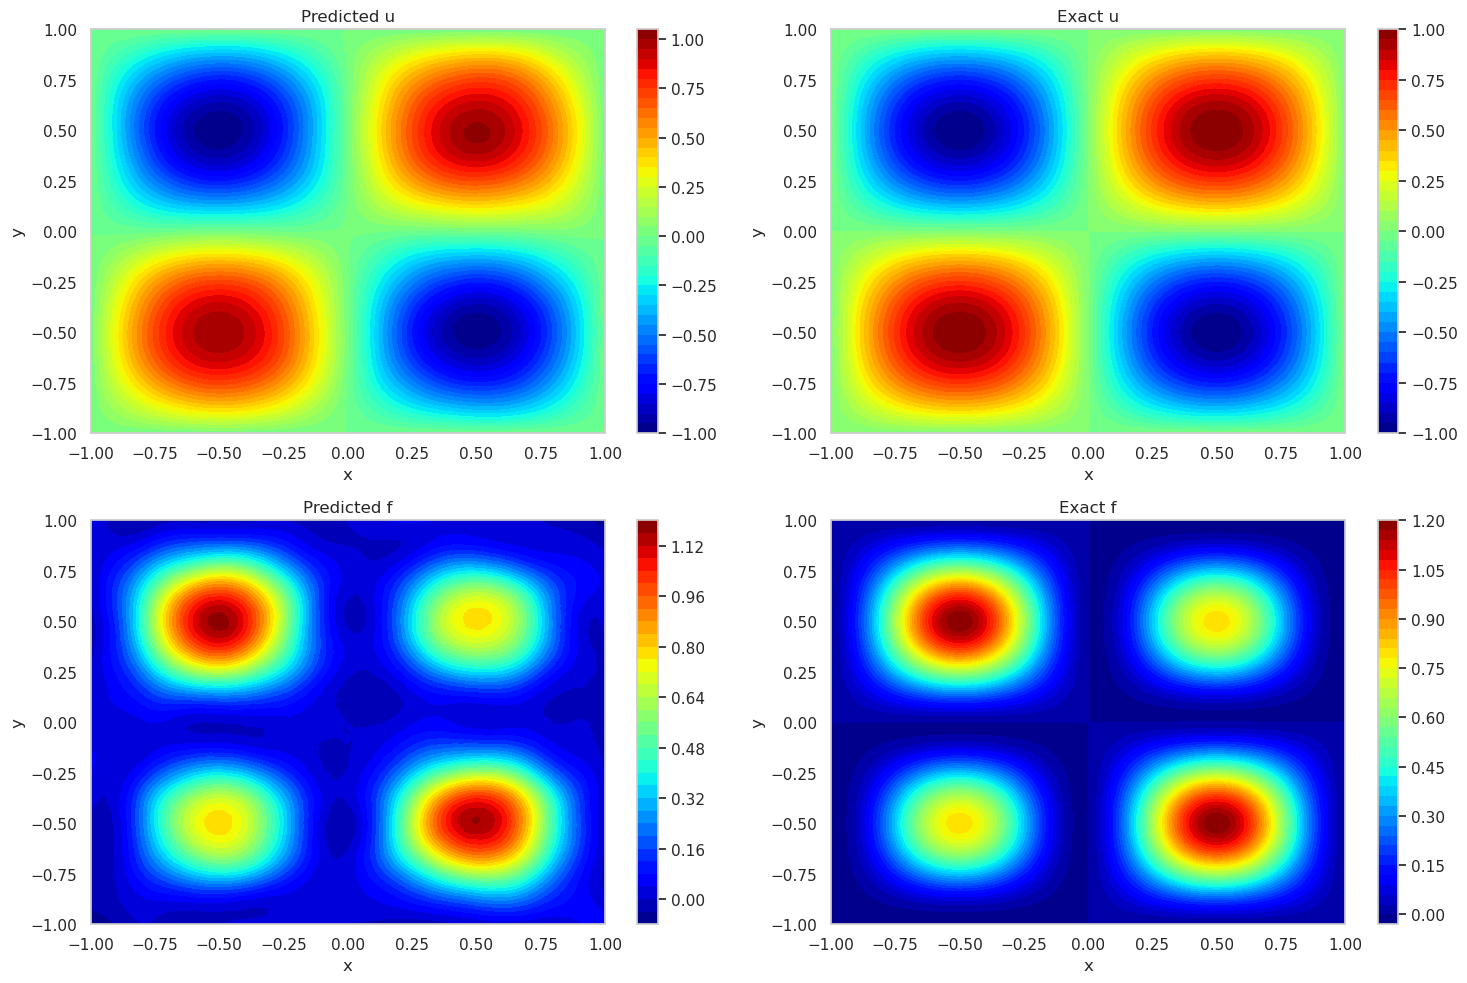

In [23]:
make_plot(net, device=net.device)

In [26]:
def plot_error(model, device=device):
    # Generate test data
    num_test_samples = 100
    x_test = torch.linspace(-1, 1, num_test_samples, device=device)
    y_test = torch.linspace(-1, 1, num_test_samples, device=device)
    x_grid, y_grid = torch.meshgrid(x_test, y_test, indexing="ij")

    x_flat = x_grid.reshape(-1)
    y_flat = y_grid.reshape(-1)

    u_preds = []
    f_preds = []

    # Process in batches
    batch_size = 100
    num_batches = (x_flat.size(0) + batch_size - 1) // batch_size  # Calculate the number of batches needed
    
    model.eval()
    with torch.no_grad():
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, x_flat.size(0))

            # Slice the batch
            x_batch = x_flat[start_idx:end_idx]
            y_batch = y_flat[start_idx:end_idx]

            # Predict for this batch
            u_pred, f_pred = model.forward(x_batch, y_batch)

            # Collect predictions
            u_preds.append(u_pred)
            f_preds.append(f_pred)

    # Concatenate all batched predictions
    u_preds = torch.cat(u_preds, dim=0)
    f_preds = torch.cat(f_preds, dim=0)

    # Reshape predictions to match the grid shape
    u_preds = u_preds.view(num_test_samples, num_test_samples)
    f_preds = f_preds.view(num_test_samples, num_test_samples)

    # Compute the exact solutions for comparison
    u_exact = exact_solution(x_grid, y_grid)
    f_exact = source_term(x_grid, y_grid)

    # Compute residuals
    u_residuals = torch.abs(u_preds - u_exact)
    f_residuals = torch.abs(f_preds - f_exact)

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Plot predicted u
    cax1 = axes[0, 0].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(),
                               u_preds.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(cax1, ax=axes[0, 0])
    axes[0, 0].set_title('Predicted u')
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('y')

    # Plot residuals for u
    cax2 = axes[0, 1].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(),
                               u_residuals.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(cax2, ax=axes[0, 1])
    axes[0, 1].set_title('Error of u')
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('y')

    # Plot predicted f
    cax3 = axes[1, 0].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(),
                               f_preds.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(cax3, ax=axes[1, 0])
    axes[1, 0].set_title('Predicted f')
    axes[1, 0].set_xlabel('x')
    axes[1, 0].set_ylabel('y')

    # Plot residuals for f
    cax4 = axes[1, 1].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(),
                               f_residuals.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(cax4, ax=axes[1, 1])
    axes[1, 1].set_title('Error of f')
    axes[1, 1].set_xlabel('x')
    axes[1, 1].set_ylabel('y')

    plt.tight_layout()
    plt.savefig('residuals_plot.png', dpi=400)  # Save the figure as a PNG file with 400 DPI
    plt.show()

Training Progress: 0epoch [00:00, ?epoch/s]


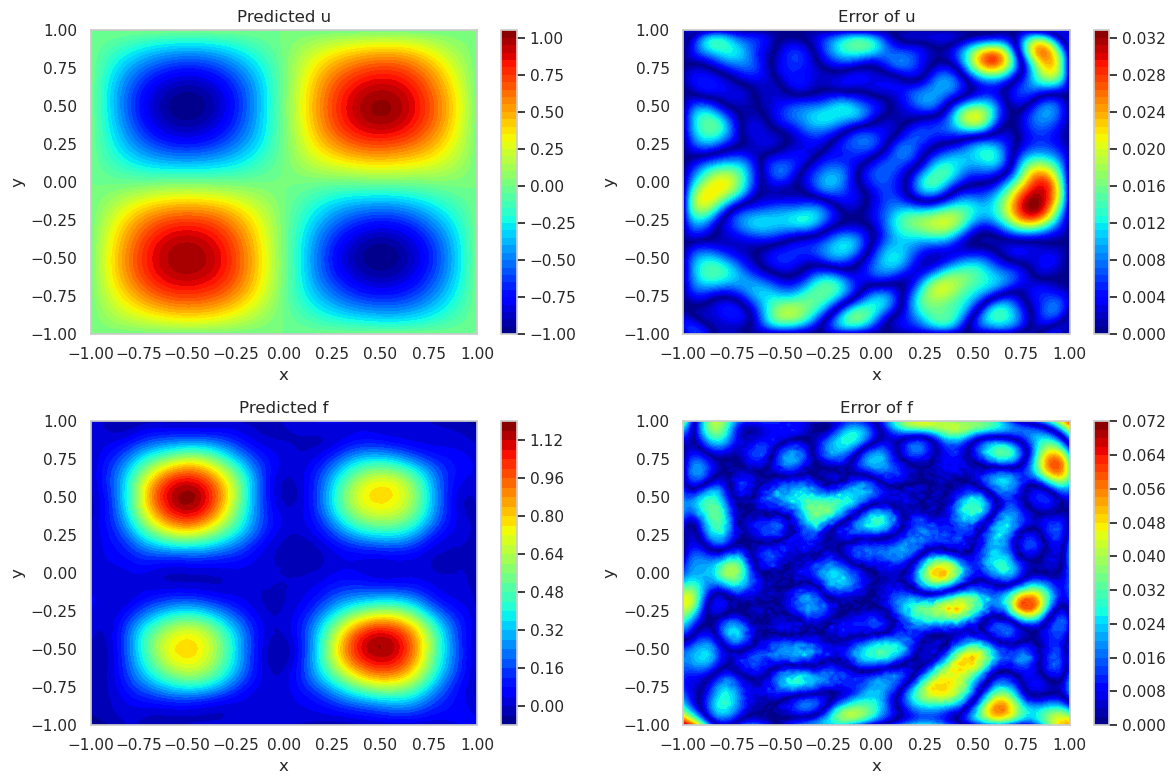

In [27]:
plot_error(net, net.device)

In [34]:
def plot_loss_history(net):
    epochs = range(len(net.total_loss_history))

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, net.total_loss_history, label='Total Loss')
    plt.plot(epochs, net.loss_interior_history, label='Interior Loss')
    plt.plot(epochs, net.loss_data_history, label='Data Loss')
    plt.plot(epochs, net.loss_bc_history, label='BC Loss')
    plt.plot(epochs, net.loss_std_history, label='STD Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
#     plt.legend()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

    plt.tight_layout()
    plt.savefig('2d_loss.png', dpi=400)  # Save the figure as a PNG file with 400 DPI
    plt.show()


def plot_loss_history_log(net):
    epochs = range(len(net.total_loss_history))

    plt.figure(figsize=(8, 6))
    plt.semilogy(epochs, net.total_loss_history, label='Total Loss')
    plt.semilogy(epochs, net.loss_interior_history, label='Interior Loss')
    plt.semilogy(epochs, net.loss_data_history, label='Data Loss')
    plt.semilogy(epochs, net.loss_bc_history, label='BC Loss')
    plt.semilogy(epochs, net.loss_std_history, label='STD Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.title('Loss Over Epochs (log scale)')
#     plt.legend()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.tight_layout()
    plt.savefig('2d_log_loss.png', dpi=400)  # Save the figure as a PNG file with 400 DPI
    plt.show()

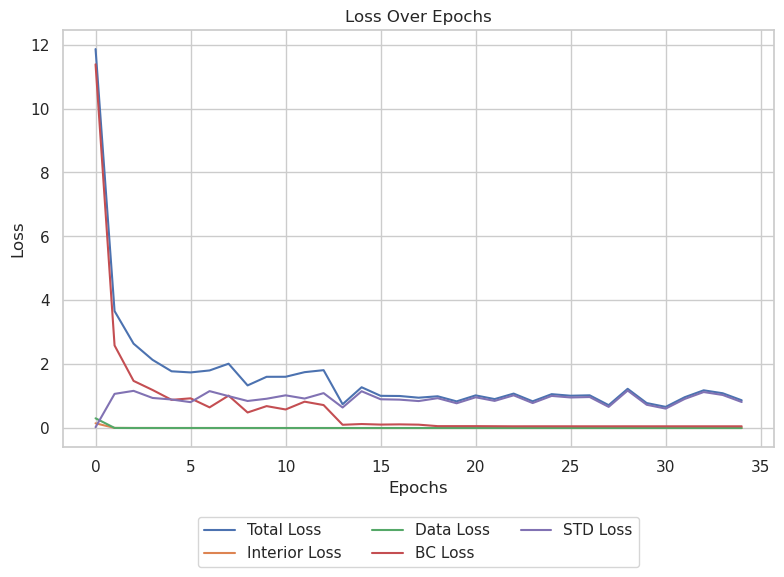

In [35]:
plot_loss_history(net)

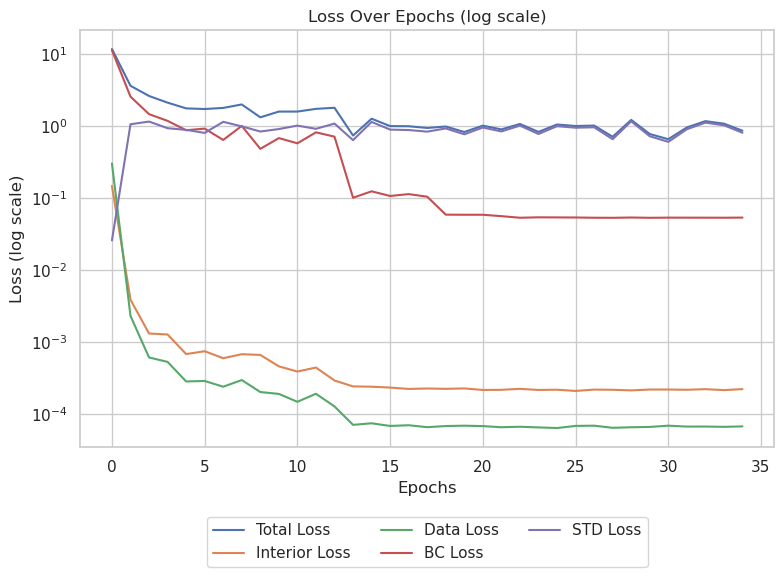

In [36]:
plot_loss_history_log(net)

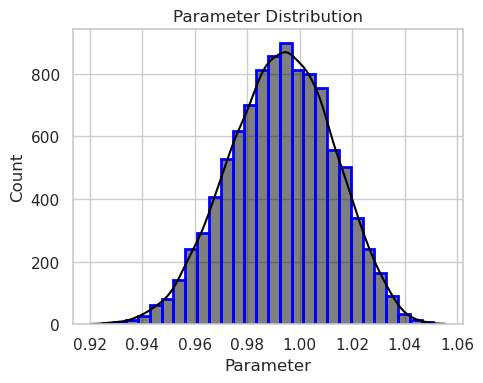

In [37]:
samples = net.sample_parameter_posterior(num_samples=10000).cpu().detach().numpy()

df = pd.DataFrame(samples, columns=['Parameter'])

plt.figure(figsize=(5, 4))  # Adjust size as needed for a single plot
sns.histplot(df['Parameter'], kde=True, linewidth=2, edgecolor='blue',
             color='black', bins =30 )
plt.title('Parameter Distribution')

plt.tight_layout()
plt.savefig("param_distribution.png", dpi=400, bbox_inches='tight')
plt.tight_layout()
plt.savefig('2d_distribution.png', dpi=400)  # Save the figure as a PNG file with 400 DPI
plt.show()

**Testing the residual plot for the whole batch of data**

In [38]:
def create_posterior_test_data(net, num_samples):
    x = torch.linspace(-1, 1, num_samples, device=net.device)  # Space domain for x
    y = torch.linspace(-1, 1, num_samples, device=net.device)  # Space domain for y

    x_grid, y_grid = torch.meshgrid(x, y, indexing="ij")
    u = exact_solution(x_grid, y_grid)
    f = source_term(x_grid, y_grid)
    
    return x_grid, y_grid, x, y

In [39]:
def forward_posterior(net, x, y, use_prior_mean=False, single_value=False):
    if not torch.is_tensor(x):
        x = torch.from_numpy(np.array(x)).float().to(net.device)
    if not torch.is_tensor(y):
        y = torch.from_numpy(np.array(y)).float().to(net.device)
        
    # Ensure x and y are properly formatted as column vectors
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    input = torch.cat((x, y), dim=1)  # Correct dimension concatenation for self.b1


    h1 = torch.tanh(net.b1(input))
    h2 = torch.tanh(net.b2(h1))

    sample_size = (1, net.hidden_size) if single_value else (input.shape[0], net.hidden_size)

    if use_prior_mean:
        prior_param_sample = torch.zeros(sample_size, device=net.device)
    else:
        prior_param_sample = torch.rand(sample_size, device=net.device)

    t1 = torch.tanh(net.t1(prior_param_sample))
    t2 = torch.tanh(net.t2(t1))
    posterior_param_sample = net.t3(t2)
    net.predicted_params = posterior_param_sample

    output = net.b3(torch.multiply(t2, h2))

    # Assuming output dimension is correct as per the layer's expectation
    u = output[:, 0]
    f = output[:, 1]

    return u, f

In [40]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2).fit(predicted_samples.detach().cpu())
print(gm.means_)

[[0.97767399]
 [1.0028542 ]]


In [41]:
predicted_samples.mean()

tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)

In [42]:
import torch
import numpy as np
from scipy import stats

def calculate_residual(net, x, y, param_vals):
    if not torch.is_tensor(param_vals):
        param_vals = torch.from_numpy(np.array(param_vals)).float().to(net.device)
            
        
    u, f = forward_posterior(net, x, y, use_prior_mean=True)
    
    # Compute derivatives
    du_dx = net.compute_derivative(u, x, 1)
    du_dy = net.compute_derivative(u, y, 1)
    d2u_dx2 = net.compute_derivative(u, x, 2)
    d2u_dy2 = net.compute_derivative(u, y, 2)
    u_squared = u ** 2  # Shape [100]
    u_squared = u_squared.view(-1, 1)


    # Apply the parameter values to the predicted_params tensor uniformly across all batches

    net.predicted_params[:] = param_vals

    # Calculate the PDE residual based on the modified predicted parameters
    residual = torch.multiply(0.01, (d2u_dx2 + d2u_dy2)).view(-1, 1) \
        + torch.multiply(net.predicted_params, u_squared) - f.view(-1, 1)

    return residual


In [44]:
def plot_posterior_residuals(net, device, param_vals,  num_samples=100, noise=0.0, ):
    
    x_grid, y_grid, x, y = create_posterior_test_data(net, num_samples)
    

    x_grid.requires_grad_(True)
    y_grid.requires_grad_(True)
    
    residuals = calculate_residual(net, x_grid, y_grid, param_vals)

    
    fig = plt.figure(figsize=(6, 3))
    ax1 = plt.subplot(121)

    size = 100
    
    abs_residuals = torch.abs(residuals).cpu().detach().numpy()
    residuals_grid = abs_residuals.reshape(size, size)  # Using reshape for clarity
        
    cax = ax1.contourf(x_grid.cpu().detach().numpy(), y_grid.cpu().detach().numpy(), residuals_grid, cmap='jet')
    plt.colorbar(cax)
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title('PDE Residual')
    
    plt.show()

# Usage example:

# plot_posterior_residuals(net, device=net.device,  param_vals=0.0,  num_samples=100, noise=0.0)


mean parameter= 0.99267596


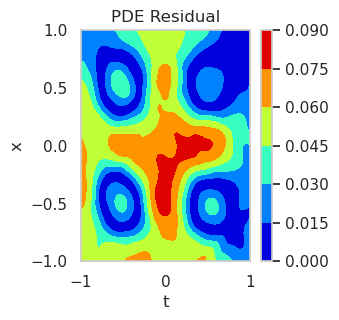

In [48]:
samples_mean = net.sample_parameter_posterior(num_samples=10000).cpu().detach().numpy().mean()
print('mean parameter=', samples_mean)
plot_posterior_residuals(net, device=net.device,  param_vals=samples_mean,  num_samples=100, noise=0.0)

mode 1 parameter= [0.97767399]


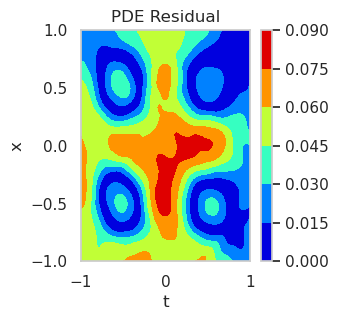

In [49]:
# "mode"
print('mode 1 parameter=',gm.means_[0])
plot_posterior_residuals(net, device=net.device,  param_vals=gm.means_[0],  num_samples=100, noise=0.0)

mode 2 parameter= [1.0028542]


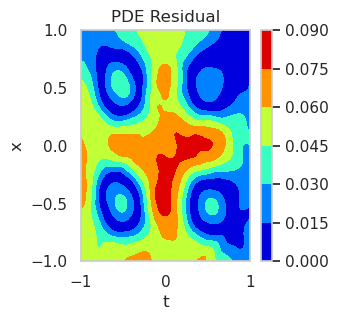

In [50]:
print('mode 2 parameter=', gm.means_[1])
# "mode2"
plot_posterior_residuals(net, device=net.device,  param_vals=gm.means_[1],  num_samples=100, noise=0.0)

In [51]:
def plot_posterior_mean_errors(model, device=device):
    # Generate test data
    num_test_samples = 100
    num_tests= 10
    x_test = torch.linspace(-1, 1, num_test_samples, device=device)
    y_test = torch.linspace(-1, 1, num_test_samples, device=device)
    x_grid, y_grid = torch.meshgrid(x_test, y_test, indexing="ij")

    x_flat = x_grid.reshape(-1)
    y_flat = y_grid.reshape(-1)

    u_preds = []
    f_preds = []

    model.eval()
    with torch.no_grad():
        for i in range(num_tests):


            # Slice the batch
            x_batch = x_flat
            y_batch = y_flat

            # Predict for this batch
            u_pred, f_pred = model.forward(x_batch, y_batch)

            # Collect predictions
            u_preds.append(u_pred)
            f_preds.append(f_pred)

    # Concatenate all batched predictions
    u_preds = torch.stack(u_preds)
    f_preds = torch.stack(f_preds)
    

    u_preds = u_preds.mean(dim=0)
    f_preds = f_preds.mean(dim=0)

    # Reshape predictions to match the grid shape
    u_preds = u_preds.view(num_test_samples, num_test_samples)
    f_preds = f_preds.view(num_test_samples, num_test_samples)

    # Compute the exact solutions for comparison
    u_exact = exact_solution(x_grid, y_grid)
    f_exact = source_term(x_grid, y_grid)

    # Compute residuals
    u_residuals = u_preds - u_exact
    f_residuals = f_preds - f_exact

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Plot predicted u
    cax1 = axes[0, 0].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(),
                               u_preds.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(cax1, ax=axes[0, 0])
    axes[0, 0].set_title(r'${\hat{u}}$')
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('y')

    # Plot residuals for u
    cax2 = axes[0, 1].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(),
                               u_residuals.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(cax2, ax=axes[0, 1])
    axes[0, 1].set_title(r'${| u - \hat{u}|}$')
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('y')

    # Plot predicted f
    cax3 = axes[1, 0].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(),
                               f_preds.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(cax3, ax=axes[1, 0])
    axes[1, 0].set_title(r'${\hat{u}}$')
    axes[1, 0].set_xlabel('x')
    axes[1, 0].set_ylabel('y')

    # Plot residuals for f
    cax4 = axes[1, 1].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(),
                               f_residuals.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(cax4, ax=axes[1, 1])
    axes[1, 1].set_title(r'${| f - \hat{f}|}$')
    axes[1, 1].set_xlabel('x')
    axes[1, 1].set_ylabel('y')

    plt.tight_layout()
    plt.savefig('residuals_plot.png', dpi=400)  # Save the figure as a PNG file with 400 DPI
    plt.show()

In [52]:
def plot_uncertainty(model, device=device):
    # Generate test data
    num_test_samples = 100
    num_tests= 10
    x_test = torch.linspace(-1, 1, num_test_samples, device=device)
    y_test = torch.linspace(-1, 1, num_test_samples, device=device)
    x_grid, y_grid = torch.meshgrid(x_test, y_test, indexing="ij")

    x_flat = x_grid.reshape(-1)
    y_flat = y_grid.reshape(-1)

    u_preds = []
    f_preds = []

    model.eval()
    with torch.no_grad():
        for i in range(num_tests):


            # Slice the batch
            x_batch = x_flat
            y_batch = y_flat

            # Predict for this batch
            u_pred, f_pred = model.forward(x_batch, y_batch)

            # Collect predictions
            u_preds.append(u_pred)
            f_preds.append(f_pred)

    # Concatenate all batched predictions
    u_preds = torch.stack(u_preds)
    f_preds = torch.stack(f_preds)
    

    u_mean = u_preds.mean(dim=0)
    f_mean = f_preds.mean(dim=0)
    
    u_std = u_preds.std(dim=0)
    f_std = f_preds.std(dim=0)

    # Reshape predictions to match the grid shape
    u_mean = u_mean.view(num_test_samples, num_test_samples)
    f_mean = f_mean.view(num_test_samples, num_test_samples)
    u_std  = u_std.view(num_test_samples, num_test_samples)
    f_std = f_std.view(num_test_samples, num_test_samples)

    # Compute the exact solutions for comparison
    u_exact = exact_solution(x_grid, y_grid)
    f_exact = source_term(x_grid, y_grid)

    # Compute error
    u_error = torch.abs(u_mean - u_exact)
    f_error = torch.abs(f_mean - f_exact)

    # Plotting
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Plot predicted u
    cax1 = axes[0, 0].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(),
                               u_mean.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(cax1, ax=axes[0, 0])
    axes[0, 0].set_title(r'${\hat{u}}$')
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('y')

    # Plot error for u
    cax2 = axes[0, 1].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(),
                               u_error.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(cax2, ax=axes[0, 1])
    axes[0, 1].set_title(r'${ |\hat{u} - u |}$')
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('y')
    
    # Plot std for u
    cax5 = axes[0, 2].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(),
                               u_std.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(cax5, ax=axes[0, 2])
    axes[0, 2].set_title(r'Predicted Uncertainty of u')
    axes[0, 2].set_xlabel('x')
    axes[0, 2].set_ylabel('y')

    # Plot predicted f
    cax3 = axes[1, 0].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(),
                               f_mean.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(cax3, ax=axes[1, 0])
    axes[1, 0].set_title(r'${\hat{u}}$')
    axes[1, 0].set_xlabel('x')
    axes[1, 0].set_ylabel('y')

    # Plot residuals for f
    cax4 = axes[1, 1].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(),
                               f_error.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(cax4, ax=axes[1, 1])
    axes[1, 1].set_title(r'${ |\hat{f} - f |}$')
    axes[1, 1].set_xlabel('x')
    axes[1, 1].set_ylabel('y')
    
    # Plot std for f
    cax6 = axes[1, 2].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(),
                               f_std.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(cax6, ax=axes[1, 2])
    axes[1, 2].set_title(r'Predicted Uncertainty of f')
    axes[1, 2].set_xlabel('x')
    axes[1, 2].set_ylabel('y')
    
    

    plt.tight_layout()
    plt.savefig('residuals_plot.png', dpi=400)  # Save the figure as a PNG file with 400 DPI
    plt.show()

Training Progress: 0epoch [00:00, ?epoch/s]


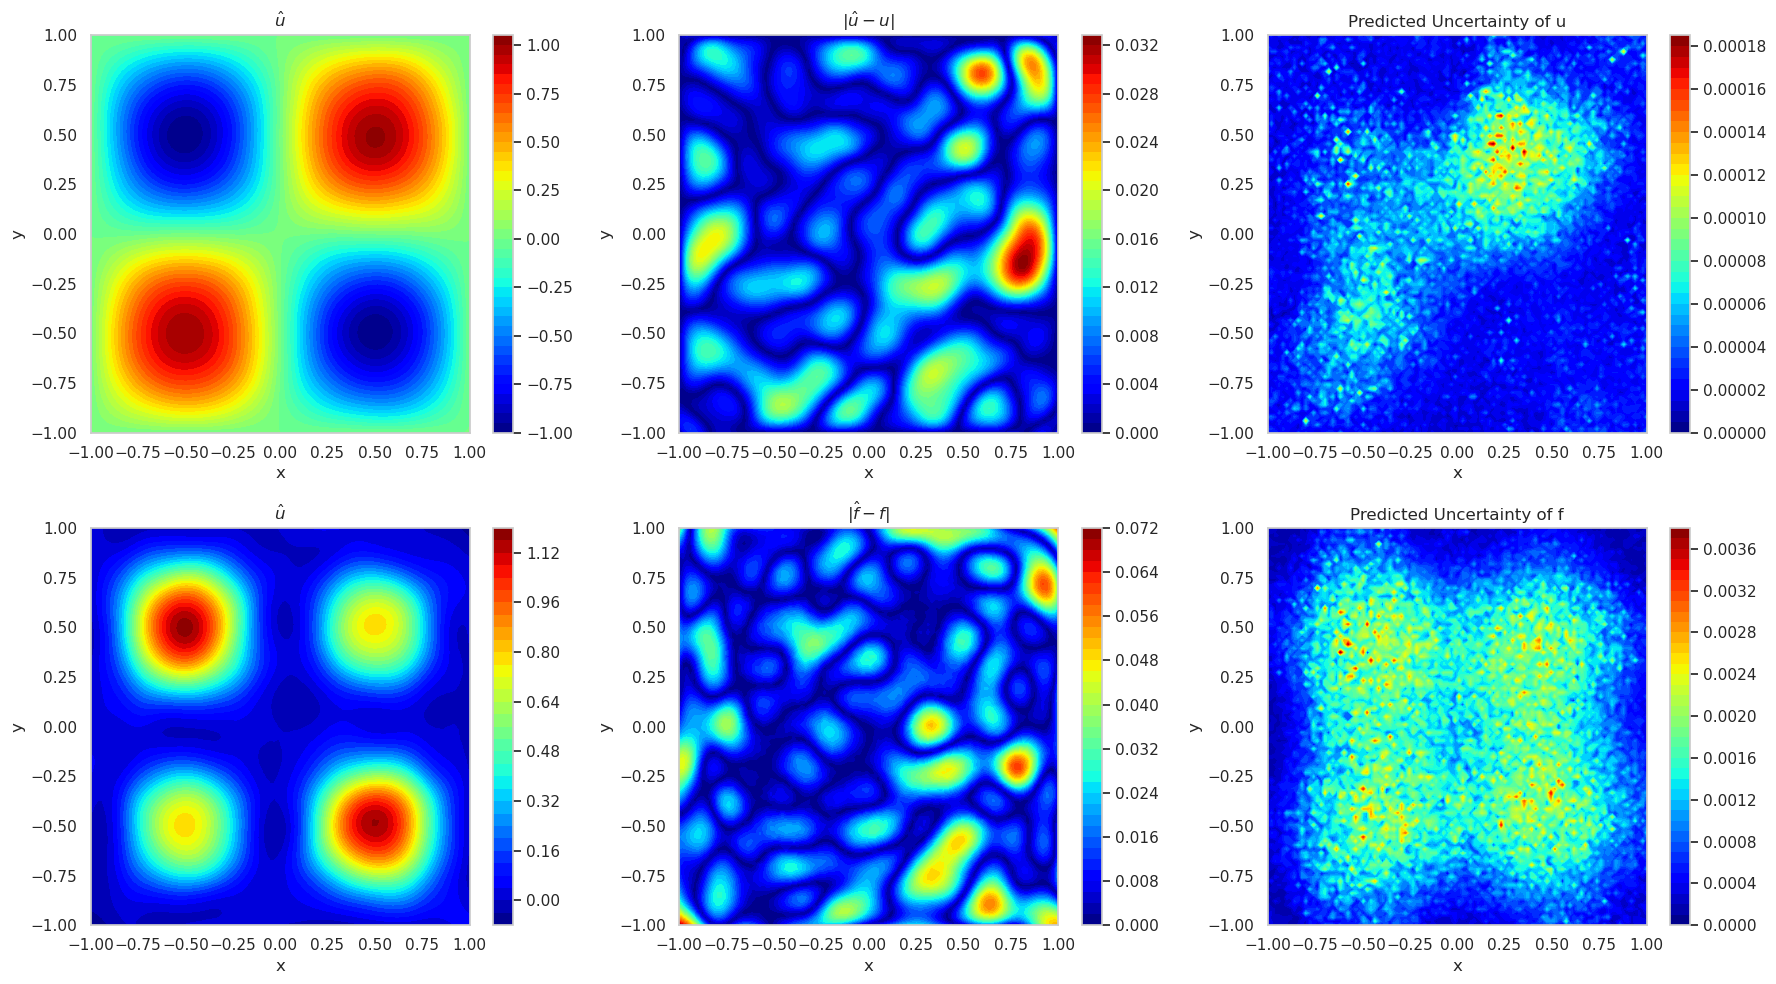

In [53]:
plot_uncertainty(net)

In [111]:
# plot_posterior_mean_errors(net)

In [54]:
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': net.optimizer.state_dict(),
    'total_loss_history': net.total_loss_history,
    'loss_interior_history': net.loss_interior_history,
    'loss_data_history': net.loss_data_history,
    'loss_bc_history': net.loss_bc_history,
    'loss_std_history': net.loss_std_history
    # Add other variables if needed
}, f'model_checkpoint_larger_uncertainty.pth')